In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm


import myokit
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols
import vc_protocols_for_myokit 

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(xs, window=1, step_size=1):
        
    times = xs[0]
    i_ion = xs[1]
              
    i_ion_window = []
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)            
        I_window = i_ion[start_index: end_index + 1]                                    
        i_ion_window.append(sum(I_window)/len(I_window))            
        t += step_size
            
    return i_ion_window

In [ ]:
from priors_JK import BeattieLogPrior as LogPrior

def log_transform_from_model_param(param):
    # Apply natural log transformation to all parameters
    out = np.copy(param)
    out = np.log(out)
    return out


def log_transform_to_model_param(param):
    # Inverse of log_transform_from_model_param()
    # Apply natural exp transformation to all parameters
    out = np.copy(param)
    out = np.exp(out)
    return out

In [3]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

### Create Voltage Protocol

The protocol is 15.4 s


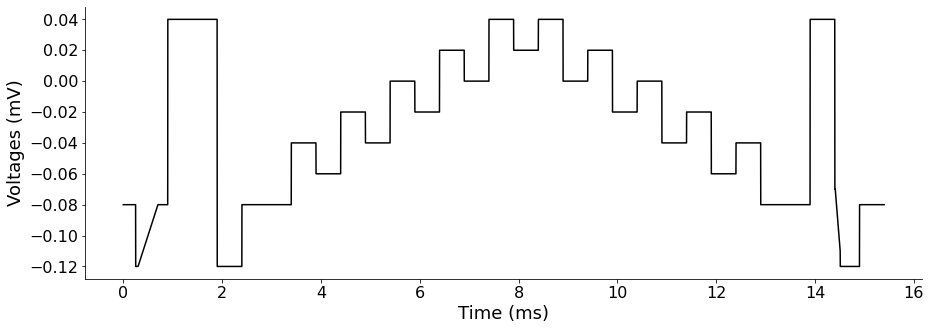

In [4]:
'''
leak_staircase
'''
# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()
VC_protocol.plot_voltage_clamp_protocol(t_eval)
print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')

In [5]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1e-3, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 2.0539603233337402 seconds ---


In [6]:
y0 = sim.pre_simulate( 100, sim_type=1)
d = sim.simulate(VC_protocol.get_voltage_change_endpoints()[-1], log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent = {
    'O': d['ikr.open']*d['ikr.active'],
    'I': d['ikr.open']*(1-d['ikr.active']),
    'C': (1-d['ikr.open'])*d['ikr.active'],
    'IC': (1-d['ikr.open'])*(1-d['ikr.active']),    
}

In [8]:
def gen_dataset( gen_params, datasetNo=1):    
    '''
    type = 'AP' or 'I" 
    params = {
        'times': 1,                    
        'log_li' : [],
        'nData' : 10000,                         
        'dataset_dir' :   './dataset',
        'data_file_name' :  'current',
        'scale' : 2,
    }  
    '''
    start_time = time.time()    
    
    random.seed(datasetNo * 84)
    np.random.seed(datasetNo * 86)

    print("-----Dataset%d generation starts.------"%(datasetNo))
    
    # Set parameter transformation
    transform_to_model_param = log_transform_to_model_param       # return np.exp(out)
    transform_from_model_param = log_transform_from_model_param   # return np.log(out)
    logprior = LogPrior(transform_to_model_param, transform_from_model_param)

    d = None              
    result_li = []
    param_li = []
    current_nData = 0
    
    simulation_error_count = 0
    with tqdm(total = gen_params['nData']) as pbar: 
        while (current_nData < gen_params['nData']):    
            
            generated_parameters = logprior.sample_without_inv_transform()

            # ikr_g = 
            # ikr_p1 = random.uniform(parameter_ranges[1][0]-epsilon, parameter_ranges[1][1]+epsilon)
            # ikr_p2 = random.uniform(parameter_ranges[2][0]-epsilon, parameter_ranges[2][1]+epsilon)
            # ikr_p3 = random.uniform(parameter_ranges[3][0]-epsilon, parameter_ranges[3][1]+epsilon)
            # ikr_p4 = random.uniform(parameter_ranges[4][0]-epsilon, parameter_ranges[4][1]+epsilon)
            # ikr_p5 = random.uniform(parameter_ranges[5][0]-epsilon, parameter_ranges[5][1]+epsilon)
            # ikr_p6 = random.uniform(parameter_ranges[6][0]-epsilon, parameter_ranges[6][1]+epsilon)
            # ikr_p7 = random.uniform(parameter_ranges[7][0]-epsilon, parameter_ranges[7][1]+epsilon)
            # ikr_p8 = random.uniform(parameter_ranges[8][0]-epsilon, parameter_ranges[8][1]+epsilon)
            # generated_parameters = np.array([ikr_g, ikr_p1, ikr_p2, ikr_p3, ikr_p4, ikr_p5, ikr_p6, ikr_p7, ikr_p8], dtype=np.float32)             
            
            model_params = {                    
                'ikr.g' : generated_parameters[0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
                'ikr.p1' : generated_parameters[1],
                'ikr.p2' : generated_parameters[2],
                'ikr.p3' : generated_parameters[3],
                'ikr.p4' : generated_parameters[4],
                'ikr.p5' : generated_parameters[5],
                'ikr.p6' : generated_parameters[6],
                'ikr.p7' : generated_parameters[7],
                'ikr.p8' : generated_parameters[8],                
            } 
            sim.set_simulation_params(model_params)                
            # log_li = ['membrane.V']
            # if len(log_li)>0:
            #     log_li = gen_params['log_li']
            try :                
                sim.pre_simulate(100, sim_type=1)           
                d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])           
                
                temp = None
                if type(gen_params['t_eval']) != type(None):
                    temp = d['ikr.IKr']    
                else:
                    temp = [d['engine.time'], d['ikr.IKr']]
                    
                if (gen_params['window']>0) and (gen_params['step_size']>0):
                    temp = get_currents_with_constant_dt(temp, window=gen_params['window'], step_size=gen_params['step_size'])
                        
                result_li.append( temp )
                param_li.append( generated_parameters )
                current_nData+=1                    

            except :
                simulation_error_count += 1
                print("There is a simulation error.")
                continue
                
            pbar.update(1) 
        
    if ((gen_params['window']>0) and (gen_params['step_size']>0)) or (type(gen_params['t_eval']) != type(None)):
        result_li = np.array(result_li)                
    else:
        result_li = np.array(result_li, dtype=object)            
    param_li = np.array(param_li)    
        
    np.save(os.path.join(gen_params['dataset_dir'], f"{gen_params['data_file_name']}{datasetNo}" ) , result_li)
    np.save(os.path.join(gen_params['dataset_dir'], f'parameter{datasetNo}' ), param_li )

    result_li = []
    param_li = []

    print("=====Dataset%d generation End.  &  %d simulation errors occured.=== %f ===="%(datasetNo, simulation_error_count, (time.time()-start_time)))       

The number of process : 72
[1]
The folder already exists.


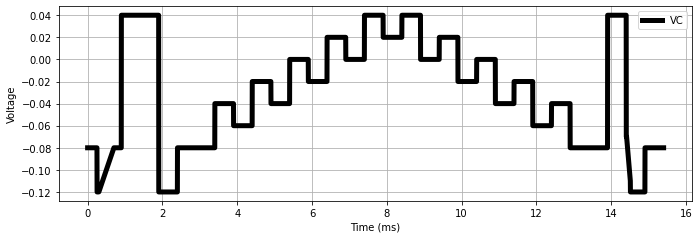

-----Dataset1 generation starts.------


 46%|██████████████████▏                     | 455/1000 [07:47<09:05,  1.00s/it]/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 6.99803e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 5.49598e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 4.518e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 3.86239e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._s

There is a simulation error.


 59%|███████████████████████▌                | 589/1000 [09:57<06:46,  1.01it/s]/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 8.79877e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 6.55778e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 1.8583e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 7.02764e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._

There is a simulation error.


 68%|███████████████████████████▎            | 684/1000 [11:31<05:12,  1.01it/s]/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 6.5439e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 1.80754e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 8.27578e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 5.18061e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._

There is a simulation error.


 89%|███████████████████████████████████▌    | 890/1000 [14:54<01:45,  1.04it/s]/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 7.03444e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 6.23346e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 5.69316e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/opt/conda/lib/python3.7/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 14.51 and h = 2.39622e-16 are such that t + h = t on the next step. The solver will continue anyway.
  t = self.

There is a simulation error.


 90%|███████████████████████████████████▉    | 898/1000 [15:02<01:45,  1.03s/it]

In [ ]:
if __name__=='__main__':
    start_time = time.time()    
    nCPU = os.cpu_count()          
    print("The number of process :", nCPU )   
   
    multi = False
    
    gen_params = {
        'end_time': VC_protocol.get_voltage_change_endpoints()[-1],    
        't_eval' : t_eval, 
        'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
        'save_log_li' : ['ikr.IKr'],
        'nData' : 1000,                         
        'dataset_dir' : f'./kylie2017_hERG_leakstaircase_77000',
        'data_file_name' : 'IKr',
        'window' : -0.01,
        'step_size' : -0.01,
        'startNo' : 1,
        'nDataset' : 1,
    }  
    # gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
    if gen_params['nDataset'] < nCPU:
        nCPU = gen_params['nDataset']
    

    datasetNo_li = list(range(gen_params['startNo'], gen_params['startNo']+gen_params['nDataset']))  # Core 수만큼  [1,2,3,4,5,6,7,8,9,10]    
    print(datasetNo_li)          
        
    try:
        if not os.path.exists(gen_params['dataset_dir']):
            os.makedirs(gen_params['dataset_dir'])
            print('"%s" has been created.'%(gen_params['dataset_dir']))
        else:
            print("The folder already exists.")
    except OSError:
        print('Error: create_folder(). : ' + gen_params['dataset_dir'])
        
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(1,1, figsize=(10,3))    
    # fig.suptitle(sim.name, fontsize=14)
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (ms)')       
    ax.set_ylabel(f'Voltage')      
    times = np.linspace(0, VC_protocol.get_voltage_change_endpoints()[-1], 10000)  
    ax.plot( times, VC_protocol.get_voltage_clamp_protocol(times), label='VC', color='k', linewidth=5)     
    ax.legend()
    ax.grid()
    # ax[-1].set_ylim(-5, 5)
    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
    plt.show()
    fig.savefig(os.path.join(gen_params['dataset_dir'], "aVC.jpg" ), dpi=100)
        
    if multi :            
        pool = multiprocessing.Pool(processes=nCPU )
        func = partial(gen_dataset, gen_params)
        pool.map(func, datasetNo_li)
        pool.close()
        pool.join()
    else:
        for No in datasetNo_li :
            gen_dataset(gen_params, No)
        
    # print("Dataset has been generated.")
    
    print("--- %s seconds ---"%(time.time()-start_time))
    
    # 

    # # Set parameter transformation
    # transform_to_model_param = log_transform_to_model_param       # return np.exp(out)
    # transform_from_model_param = log_transform_from_model_param   # return np.log(out)
    
    # logprior = LogPrior(transform_to_model_param, transform_from_model_param)
      
    # p = logprior.sample_without_inv_transform()
    # print(p)
    
    # print(logprior.rmax)
    # print(logprior.rmin)
    # print(5e5)

 

In [1]:
print("Finish")

Finish
